In [1]:
import os
import pathlib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import shutil
import random
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, Activation, GlobalMaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import splitfolders

In [2]:
# splits dataset it into three subfolders: train, val (validation), and test.

splitfolders.ratio(r"C:\Users\ajayk\Desktop\InnoProjects\SRIT\Fracture\Dataset", output="output",
    seed=1337, ratio=(.75, .2, .05), group_prefix=None, move=False)

Copying files: 671 files [00:01, 638.68 files/s]


In [3]:
data_dir = pathlib.Path('output/')
train_dir = 'output/train'
val_dir = 'output/val'
test_dir = 'output/test'

In [4]:
class_name = np.array(sorted([item.name for item in data_dir.glob("*")]))
print(class_name)

['test' 'train' 'val']


In [5]:
for dirpath, dirnames, filenames in os.walk('output'):
  print(f"{len(dirnames)} folder and {len(filenames)} images in {dirpath}")

3 folder and 0 images in output
4 folder and 0 images in output\test
0 folder and 8 images in output\test\Avulsion fracture
0 folder and 12 images in output\test\Comminuted fracture
0 folder and 8 images in output\test\Compression-Crush fracture
0 folder and 9 images in output\test\Impacted fracture
4 folder and 0 images in output\train
0 folder and 105 images in output\train\Avulsion fracture
0 folder and 164 images in output\train\Comminuted fracture
0 folder and 112 images in output\train\Compression-Crush fracture
0 folder and 120 images in output\train\Impacted fracture
4 folder and 0 images in output\val
0 folder and 28 images in output\val\Avulsion fracture
0 folder and 43 images in output\val\Comminuted fracture
0 folder and 30 images in output\val\Compression-Crush fracture
0 folder and 32 images in output\val\Impacted fracture


In [6]:
def view_random_image(target_dir, target_class):
    target_folder = target_dir + target_class
    random_image = random.sample(os.listdir(target_folder), 1)
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off")
    
    print(f"Image Shape : {img.shape}")
    plt.show()

Image Shape : (942, 1024)


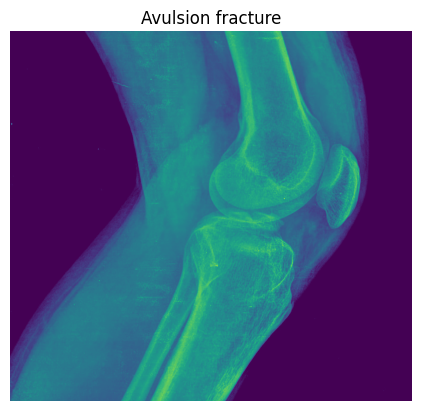

In [7]:
for i in range(1,2):
    img_n = view_random_image(target_dir='output/train/', target_class='Avulsion fracture')

Image Shape : (1600, 1259, 3)


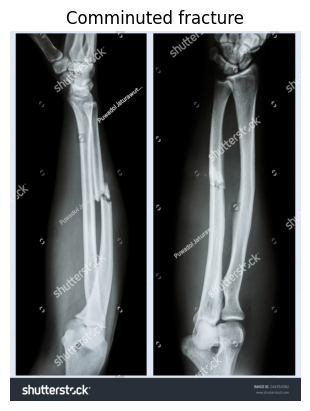

In [8]:
for i in range(1,2):
    img_n = view_random_image(target_dir='output/train/', target_class='Comminuted fracture')

Image Shape : (550, 350)


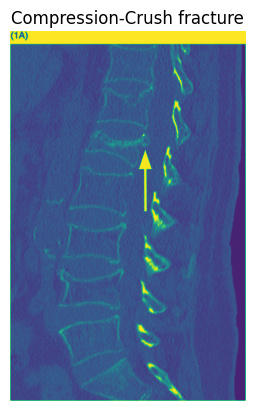

In [9]:
for i in range(1,2):
    img_n = view_random_image(target_dir='output/train/', target_class='Compression-Crush fracture')

Image Shape : (1179, 678)


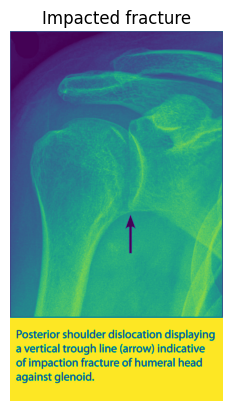

In [10]:
for i in range(1,2):
    img_n = view_random_image(target_dir='output/train/', target_class='Impacted fracture')

In [11]:
# Sets the global random seed.
tf.random.set_seed(46)

# preprocess data
train_datagen = ImageDataGenerator(rescale=1/255.0,
                                   rotation_range=0.2,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   vertical_flip=True,
                                   horizontal_flip=True)
valid_datagen = ImageDataGenerator(rescale=1/255.0)
test_datagen = ImageDataGenerator(rescale=1/255.0)

In [12]:
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=64,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=46)

valid_data = valid_datagen.flow_from_directory(val_dir,
                                               batch_size=64,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               shuffle=False,
                                               seed=46)

test_data = test_datagen.flow_from_directory(test_dir,
                                               batch_size=64,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               shuffle=False,
                                               seed=46)

Found 491 images belonging to 4 classes.
Found 131 images belonging to 4 classes.
Found 36 images belonging to 4 classes.


In [13]:
train_data.class_indices

{'Avulsion fracture': 0,
 'Comminuted fracture': 1,
 'Compression-Crush fracture': 2,
 'Impacted fracture': 3}

In [14]:
train_y=train_data.classes
val_y=valid_data.classes
test_y=test_data.classes

In [15]:
print("train_y.shape: ", train_y.shape)
print("val_y.shape: ", val_y.shape)
print("test_y.shape: ", test_y.shape)

train_y.shape:  (491,)
val_y.shape:  (131,)
test_y.shape:  (36,)


In [16]:
base_model = tf.keras.applications.DenseNet121(input_shape=(224, 224, 3),
                                                        include_top=False,
                                                        weights='imagenet')
base_model.trainable = False

In [17]:
global_average_layer = GlobalAveragePooling2D()
prediction_layer = Dense(4)
softmax = Activation('softmax')

inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = Dropout(0.25)(x)
x = global_average_layer(x)
outputs = prediction_layer(x)
outputs = softmax(outputs)

model = Model(inputs, outputs)

In [18]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         4,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 4)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,041,604 (26.86 MB)

 Trainable params: 4,100 (16.02 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [19]:
plot_model(model, show_shapes=True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [20]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

# train model
history = model.fit(train_data, epochs=50, validation_data=valid_data)

Epoch 1/50


C:\Users\ajayk\anaconda3\envs\py310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 60s 6s/step - accuracy: 0.2518 - loss: 1.5035 - val_accuracy: 0.3817 - val_loss: 1.3790
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 45s 5s/step - accuracy: 0.3629 - loss: 1.3399 - val_accuracy: 0.4275 - val_loss: 1.2984
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 45s 5s/step - accuracy: 0.4399 - loss: 1.2566 - val_accuracy: 0.5420 - val_loss: 1.1961
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 43s 5s/step - accuracy: 0.4363 - loss: 1.2176 - val_accuracy: 0.4580 - val_loss: 1.1607
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 46s 5s/step - accuracy: 0.4632 - loss: 1.1359 - val_accuracy: 0.5649 - val_loss: 1.1003
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 52s 6s/step - accuracy: 0.5025 - loss: 1.0932 - val_accuracy: 0.5344 - val_loss: 1.0771
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 47s 5s/step - accuracy: 0.5308 - loss: 1.0386 - val_accuracy: 0.5649 - val_loss: 1.0525
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 46s 5s/step - accuracy: 0.5619 - loss: 0.9699 - val_accuracy: 0.5725 - val_loss: 1.0345
Epoch 9/50
8/8 ━━━━

In [21]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(loss))

  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title("Loss Curves")
  plt.xlabel("Epochs")
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title("Accuracy Curves")
  plt.xlabel("Epochs")
  plt.legend()

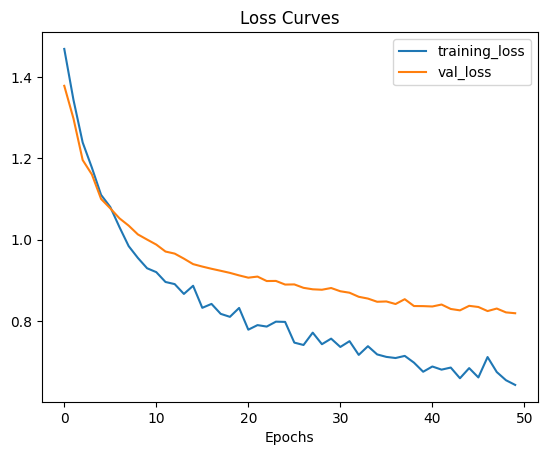

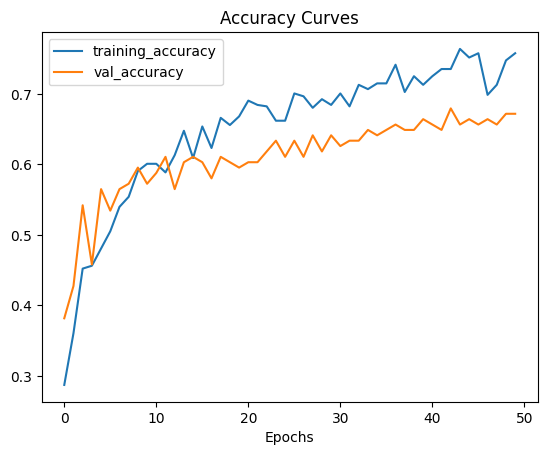

In [22]:
plot_loss_curves(history)

In [23]:
val_pred = model.predict(valid_data)
val_pred = val_pred.argmax(axis=1)
print(classification_report(val_pred, val_y))

3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step
              precision    recall  f1-score   support

           0       0.74      0.61      0.67        33
           1       0.67      0.64      0.66        45
           2       0.86      0.83      0.85        30
           3       0.44      0.61      0.51        23

    accuracy                           0.67       131
   macro avg       0.68      0.67      0.67       131
weighted avg       0.69      0.67      0.68       131



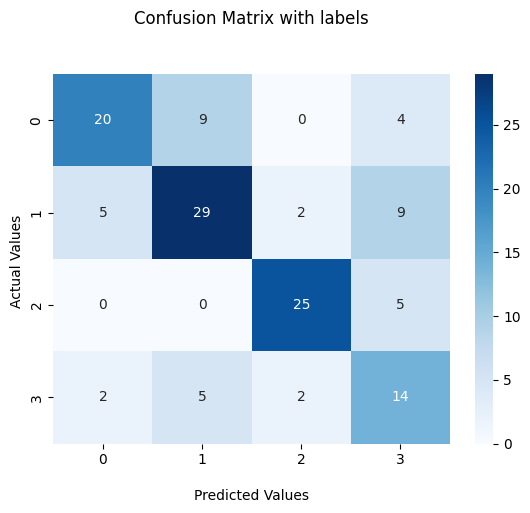

In [24]:
cfm_val = confusion_matrix(val_pred, val_y)
ax = sns.heatmap(cfm_val, annot=True, 
            cmap='Blues')

# Preparation for plotting confusion matrix
ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

# Display the visualization of the Confusion Matrix.
plt.show()

In [25]:
test_pred = model.predict(test_data)
test_pred = test_pred.argmax(axis=1)
print(classification_report(test_pred, test_y))

C:\Users\ajayk\anaconda3\envs\py310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
              precision    recall  f1-score   support

           0       0.12      0.33      0.18         3
           1       0.58      0.78      0.67         9
           2       0.88      0.78      0.82         9
           3       0.62      0.33      0.43        15

    accuracy                           0.56        36
   macro avg       0.55      0.56      0.53        36
weighted avg       0.64      0.56      0.57        36



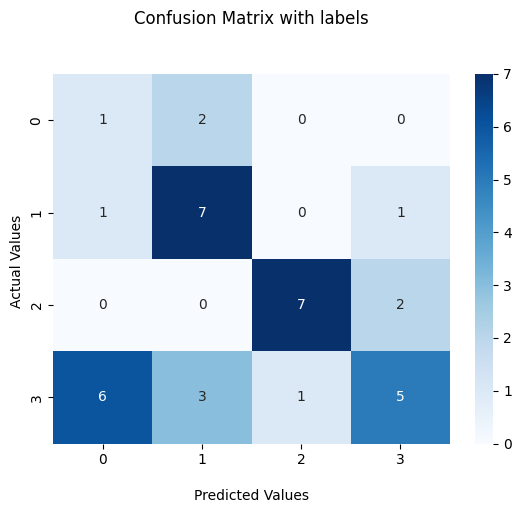

In [26]:
cfm_test = confusion_matrix(test_pred, test_y)
ax = sns.heatmap(cfm_test, annot=True, 
            cmap='Blues')

# Preparation for plotting confusion matrix
ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

# Display the visualization of the Confusion Matrix.
plt.show()

In [27]:
model.save('my_model.keras')

In [28]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted Class: Compression-Crush fracture


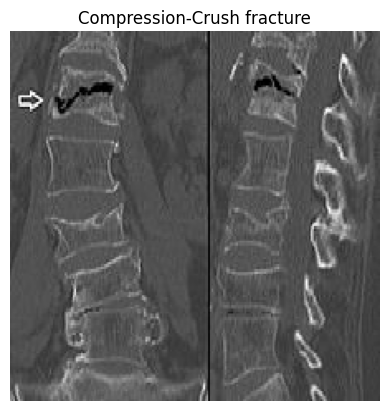

In [29]:
import matplotlib.pyplot as plt
from keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the trained model
model = load_model('my_model.keras')

# Load the image
image_path = r"C:\Users\ajayk\Desktop\InnoProjects\SRIT\Fracture\Dataset\Compression-Crush fracture\220px-Intravertebral_vacuum_cleft_sign.jpg"
image = image.load_img(image_path, target_size=(224, 224))

# Preprocess the image
img = np.array(image)
img = img / 255.0
img = img.reshape(1, 224, 224, 3)

# Predict the label
label = model.predict(img)

# Determine the predicted class
class_names = ['Avulsion fracture', 'Comminuted fracture', 'Compression-Crush fracture', 'Impacted fracture']
predicted_class_index = np.argmax(label)
predicted_class = class_names[predicted_class_index]

# Print the predicted class
print("Predicted Class:", predicted_class)

# Display the image with the predicted label
plt.imshow(image)
plt.title(predicted_class)
plt.axis('off')
plt.show()
